In [39]:
import json
import os 
import sys

import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import math
import pybamm

from myPackage.utils import show_image, kmeans_color_quantization, crop_image_white_background, euclidean_calculation, closest_point
from myPackage.utils import silhouette_analysis_of_kmeans_image_clustering, detect_SEM_scale_information, plot_top_two_quantized_images, show_histogram, remove_outliers, find_particle_size_cathode, elbow_analysis
from myPackage.utils import crop_information_bar, find_particle_size_anode, thresholding_range, find_radius_particle

from scipy.spatial import distance 
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
from skimage.io import imread 
from skimage.filters import threshold_multiotsu
from random import choice



In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Anode analysis

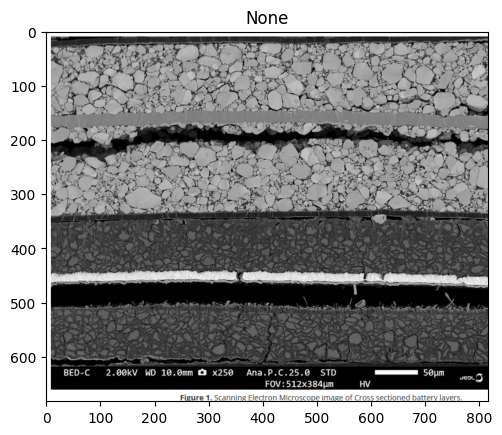

<Axes: title={'center': 'None'}>

In [15]:
#Load images
imageFile = 'cathodeXSection.png'
readImage = cv2.imread(imageFile)
original = readImage.copy()
analyzable_image = readImage[:330,:]
new_original =analyzable_image.copy()
analyzable_image_containing_SEM_info = readImage[330:, :]
show_image(original)

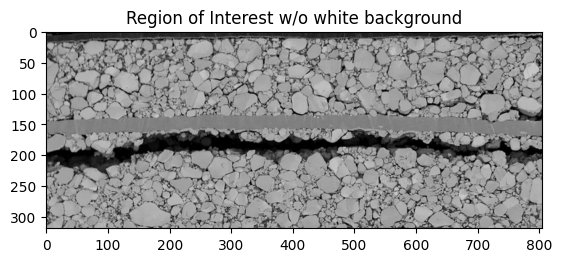

In [16]:
#We are interested in the cathode section of the image, get rid of white boundaries
analyzable_image = crop_image_white_background(analyzable_image)

x,y,w,h are (608, 53, 78, 3)


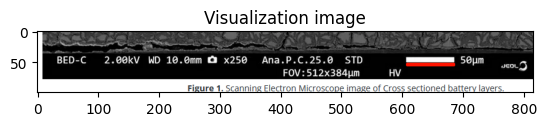

Scale Bar Detected: Width=78 pixels, Height=3 pixels
Scale length per pixel: 0.6410256410256411 um/pixel
Area per area pixel: 0.4109138724523341 um^2/pixel^2


In [17]:
#Still need the original image to gather information on length and area scale
length_per_pixel, area_per_pixel  = detect_SEM_scale_information(original)

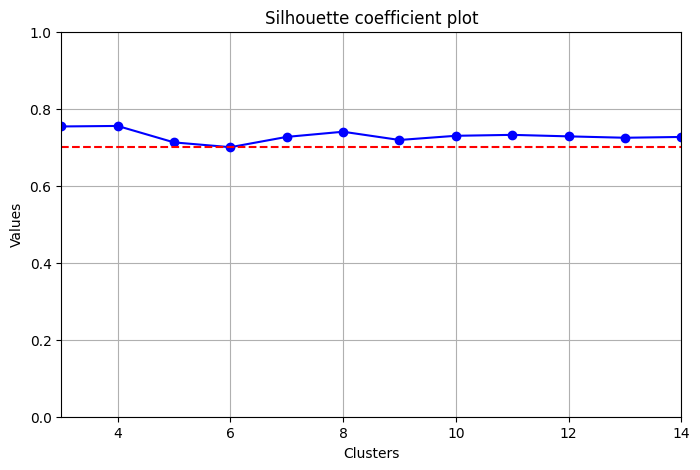

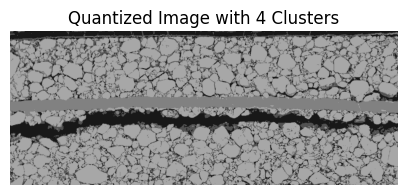

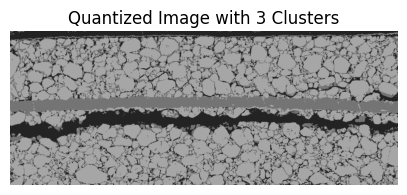

[4, 3]

In [19]:
#Analyze for optimal number of clusters
cluster_number = range(3,15)

cluster_dictionary = silhouette_analysis_of_kmeans_image_clustering(analyzable_image, cluster_number)

plot_top_two_quantized_images(analyzable_image, cluster_dictionary)

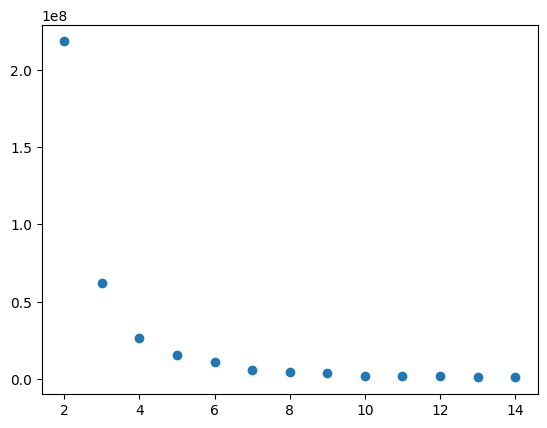

In [20]:
#Elbow analysis
cluster_number = range(2,15)
rounds = 1
compact_array = elbow_analysis(analyzable_image,cluster_number, rounds)

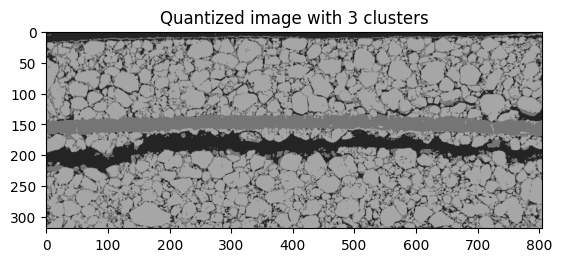

<Axes: title={'center': 'Quantized image with 3 clusters'}>

In [23]:
#Choosing 3 as the optimal number of clusters due to prior knowledge and silhouette analysis
k = 3
kmeans_cathode, compactness, centers, labels = kmeans_color_quantization(analyzable_image, clusters = k)
show_image(kmeans_cathode, title =f"Quantized image with {k} clusters" )



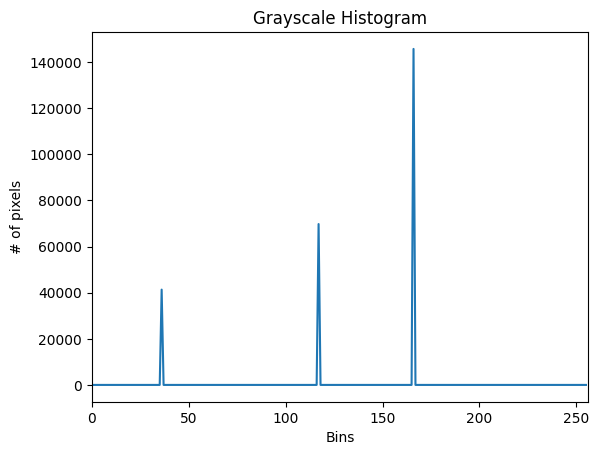

In [24]:
cathode_hist = show_histogram(kmeans_cathode)

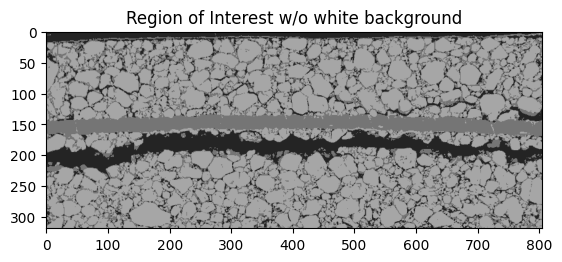

141.5


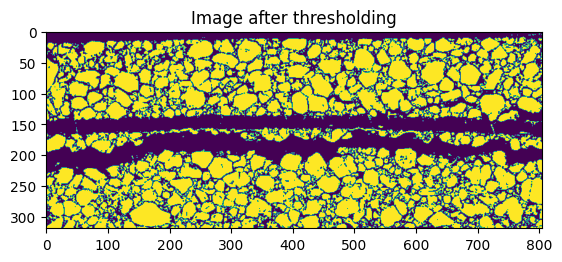

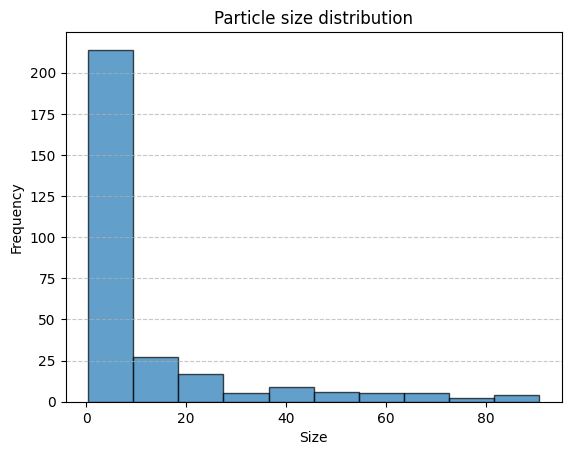

In [26]:
size_list_cathode = find_particle_size_cathode(kmeans_cathode,histogram=cathode_hist, per_pixel_area=area_per_pixel)

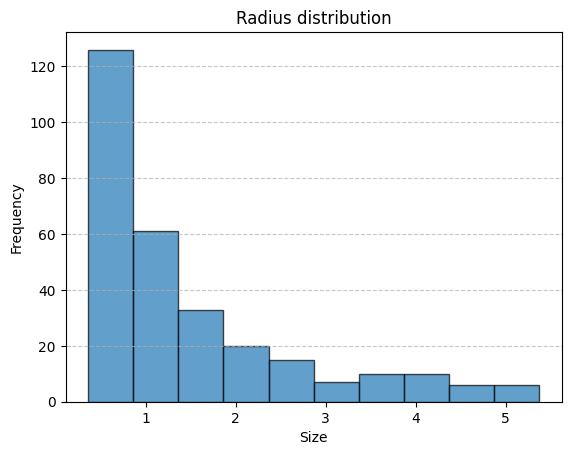

In [28]:
#Find radius distribution of the image

radius_list_cathode = find_radius_particle(size_list_cathode)

# Anode Analysis


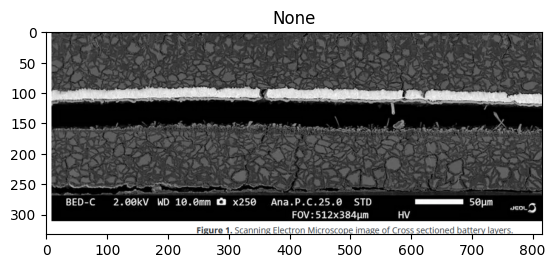

<Axes: title={'center': 'None'}>

In [29]:
#Testing for silhouette analysis
imageFile = 'cathodeXSection.png'
readImage = cv2.imread(imageFile)
original = readImage.copy()
analyzable_image = readImage[:330,:] #Needs a bit mo
negative_electrode_image = readImage[350:]

new_original =analyzable_image.copy()
analyzable_image_containing_SEM_info = readImage[330:, :]
show_image(negative_electrode_image)

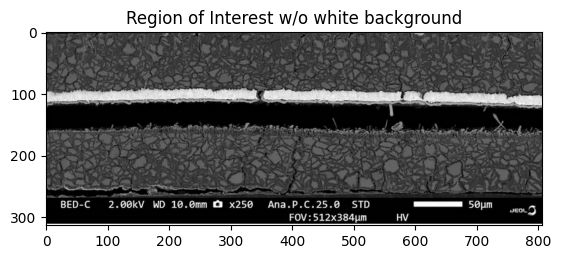

In [30]:
negative_electrode_image = crop_image_white_background(negative_electrode_image)

x,y,w,h are (608, 53, 78, 3)


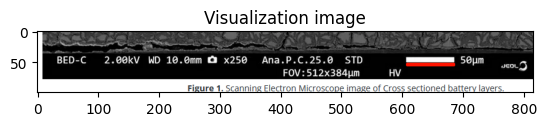

Scale Bar Detected: Width=78 pixels, Height=3 pixels
Scale length per pixel: 0.6410256410256411 um/pixel
Area per area pixel: 0.4109138724523341 um^2/pixel^2


In [31]:
#Still need the original image to gather information on length and area scale
length_per_pixel, area_per_pixel  = detect_SEM_scale_information(original)

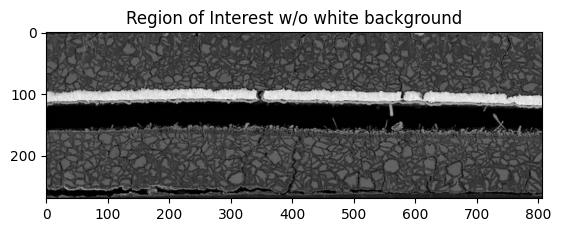

In [32]:
anode_only_image = crop_information_bar(negative_electrode_image)

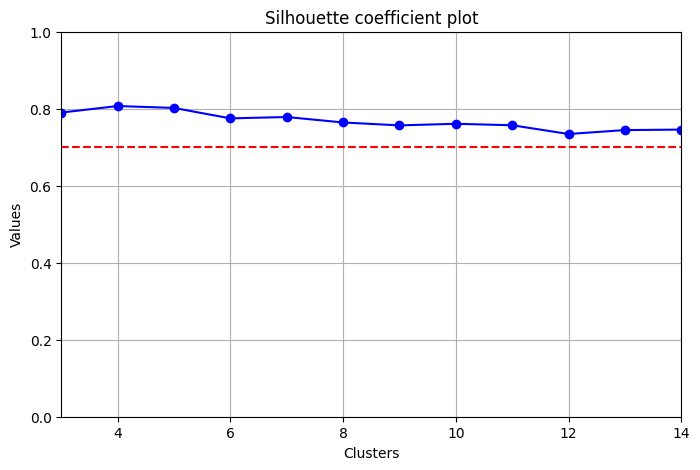

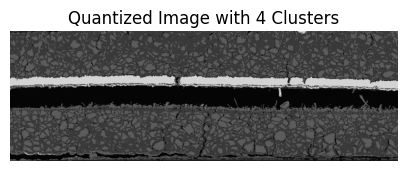

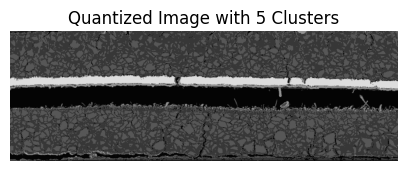

[4, 5]

In [33]:
#Analyze for optimal number of clusters
cluster_number = range(3,15)

cluster_dictionary = silhouette_analysis_of_kmeans_image_clustering(anode_only_image, cluster_number)

plot_top_two_quantized_images(anode_only_image, cluster_dictionary)

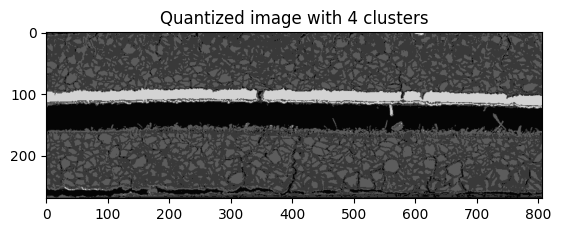

<Axes: title={'center': 'Quantized image with 4 clusters'}>

In [34]:
k = 4
kmeans_anode, compactness, centers, labels = kmeans_color_quantization(anode_only_image, clusters = k)
show_image(kmeans_anode, title =f"Quantized image with {k} clusters" )

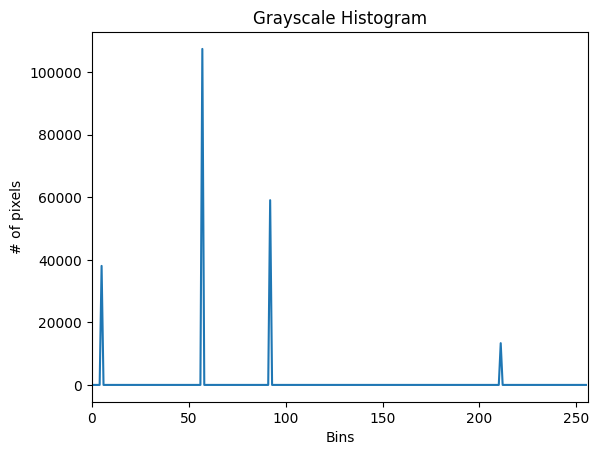

In [35]:
hist_anode = show_histogram(kmeans_anode)

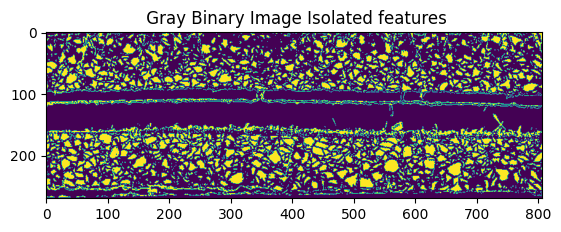

In [36]:
thresholded_image_anode = thresholding_range(kmeans_anode, 70,100 )


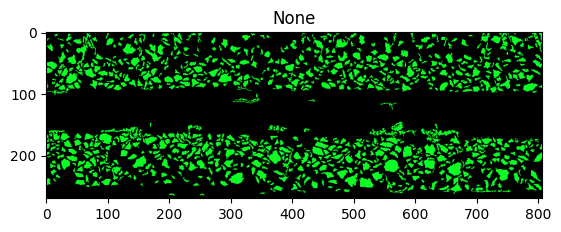

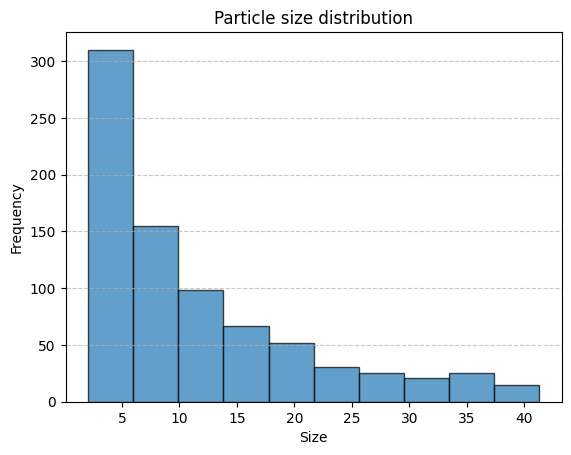

In [37]:
anode_distribution = find_particle_size_anode(thresholded_image_anode, kmeans_anode, area_per_pixel)

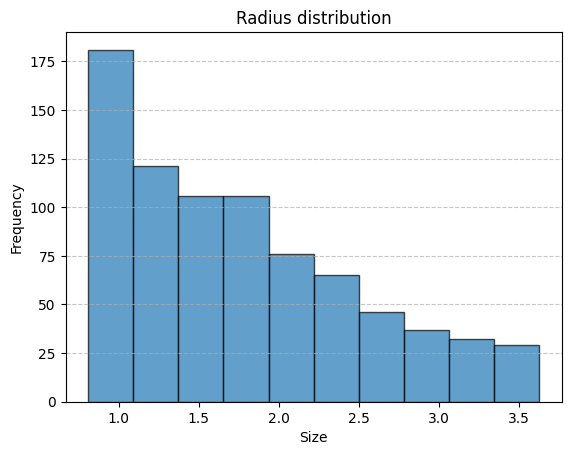

In [38]:
#Find radius distribution of the image

radius_list_anode = find_radius_particle(anode_distribution)

### DFN simulation

Following the example detailed in this website: https://colab.research.google.com/github/pybamm-team/PyBaMM/blob/main/docs/source/examples/notebooks/models/DFN-with-particle-size-distributions.ipynb

In [40]:

# choose option(s)
options = {"particle size": "distribution"}

# load model
model = pybamm.lithium_ion.DFN(options=options, name="MP-DFN")

In [16]:
# Base parameter set (no distribution parameters by default)
params = pybamm.ParameterValues("Marquis2019")

# Add distribution parameters to the set, with default values (lognormals)
params = pybamm.get_size_distribution_parameters(params)

In [18]:
# load parameter values into simuluation
solver = pybamm.CasadiSolver(mode="fast")
sim = pybamm.Simulation(model, parameter_values=params, solver=solver)

# solve
sim.solve(t_eval=[0, 3500])

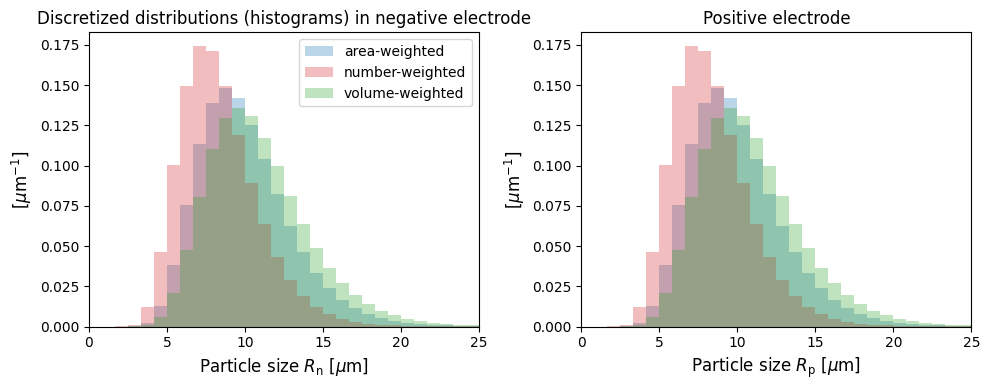

In [19]:
# The discrete sizes or "bins" used
R_p = sim.solution["Positive particle sizes [m]"].entries[
    :, 0, 0
]  # const in the x and current collector direction
R_n = sim.solution["Negative particle sizes [m]"].entries[:, 0, 0]

# The distributions (number, area, and volume-weighted)
f_a_p = sim.solution[
    "X-averaged positive area-weighted particle-size distribution [m-1]"
].entries[:, 0]
f_num_p = sim.solution[
    "X-averaged positive number-based particle-size distribution [m-1]"
].entries[:, 0]
f_v_p = sim.solution[
    "X-averaged positive volume-weighted particle-size distribution [m-1]"
].entries[:, 0]
f_a_n = sim.solution[
    "X-averaged negative area-weighted particle-size distribution [m-1]"
].entries[:, 0]
f_num_n = sim.solution[
    "X-averaged negative number-based particle-size distribution [m-1]"
].entries[:, 0]
f_v_n = sim.solution[
    "X-averaged negative volume-weighted particle-size distribution [m-1]"
].entries[:, 0]

# plot
f, axs = plt.subplots(1, 2, figsize=(10, 4))

# negative electrode
width_n = (R_n[-1] - R_n[-2]) / 1e-6
axs[0].bar(
    R_n / 1e-6,
    f_a_n * 1e-6,
    width=width_n,
    alpha=0.3,
    color="tab:blue",
    label="area-weighted",
)
axs[0].bar(
    R_n / 1e-6,
    f_num_n * 1e-6,
    width=width_n,
    alpha=0.3,
    color="tab:red",
    label="number-weighted",
)
axs[0].bar(
    R_n / 1e-6,
    f_v_n * 1e-6,
    width=width_n,
    alpha=0.3,
    color="tab:green",
    label="volume-weighted",
)
axs[0].set_xlim((0, 25))
axs[0].set_xlabel("Particle size $R_{\mathrm{n}}$ [$\mu$m]", fontsize=12)
axs[0].set_ylabel("[$\mu$m$^{-1}$]", fontsize=12)
axs[0].legend(fontsize=10)
axs[0].set_title("Discretized distributions (histograms) in negative electrode")

# positive electrode
width_p = (R_p[-1] - R_p[-2]) / 1e-6
axs[1].bar(
    R_p / 1e-6,
    f_a_p * 1e-6,
    width=width_p,
    alpha=0.3,
    color="tab:blue",
    label="area-weighted",
)
axs[1].bar(
    R_p / 1e-6,
    f_num_p * 1e-6,
    width=width_p,
    alpha=0.3,
    color="tab:red",
    label="number-weighted",
)
axs[1].bar(
    R_p / 1e-6,
    f_v_p * 1e-6,
    width=width_p,
    alpha=0.3,
    color="tab:green",
    label="volume-weighted",
)
axs[1].set_xlim((0, 25))
axs[1].set_xlabel("Particle size $R_{\mathrm{p}}$ [$\mu$m]", fontsize=12)
axs[1].set_ylabel("[$\mu$m$^{-1}$]", fontsize=12)
axs[1].set_title("Positive electrode")
plt.tight_layout()
plt.show()

### Edge detection (in construction)

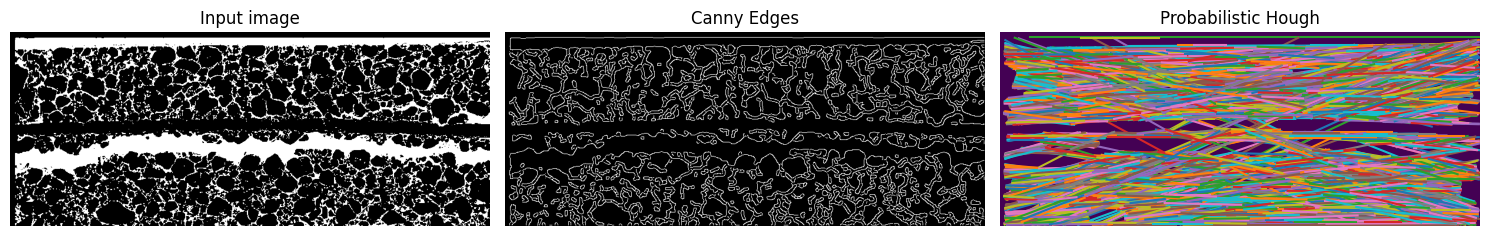

In [40]:
#Implementing line detecting 

# edges = canny(new_result, 4.5,1,125) #Have to use gray image here 

angleLow = math.radians(60)
angleHigh = math.radians(120)

edges = canny(new_result,2,1,131)

lines = probabilistic_hough_line(edges, threshold = 10,line_gap = 50, theta=np.arange(angleLow, angleHigh, 10**(-4)))



#Generating figure 2
fig,axes = plt.subplots(1,3,figsize = (15,5), sharex = True, sharey = True)
ax = axes.ravel()

ax[0].imshow(new_result[:,:], cmap = cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap = cm.gray)
ax[1].set_title('Canny Edges')

ax[2].imshow(edges * 0)



for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]),(p0[1], p1[1]))
ax[2].set_xlim((0,new_result.shape[1]))
ax[2].set_ylim((new_result.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()
plt.tight_layout()
plt.show()

(0.0, 256.0)

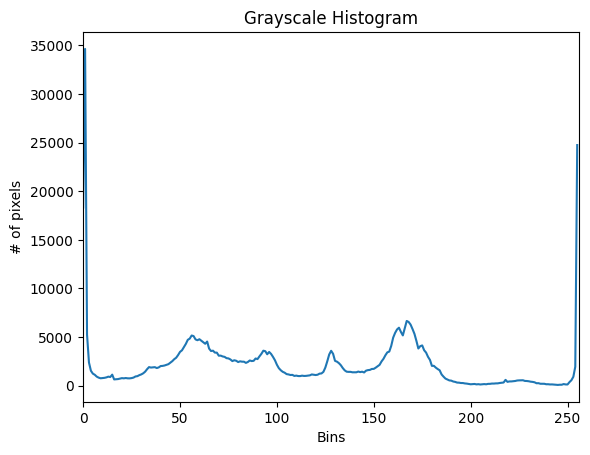

In [39]:
#Calculate histogram of this image

hist = cv2.calcHist([readImage], [0], None, [256], [0,256])
normalizeHist = hist/hist.sum() 


plt.figure()
plt.title('Grayscale Histogram')
plt.xlabel('Bins')
plt.ylabel('# of pixels')
plt.plot(hist)
plt.xlim([0,256])


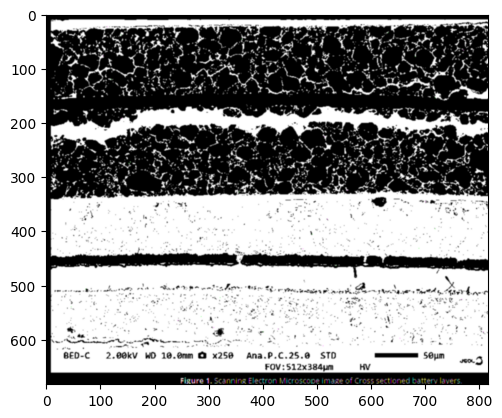

<Axes: >

In [37]:
#Highlighting the field based on grayscale values

threshold = 100
assignValue = 255
thresholdMethod = cv2.THRESH_BINARY_INV

_, result = cv2.threshold(readImage, threshold, assignValue, thresholdMethod)

showImage(result)